In [1]:
import numpy as np
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm, trange

from gltfraytracer import Scene3D

In [2]:
def array_stats(a):
    print('shape: ', a.shape, a.dtype, '| total size:', a.nbytes/2**30, 'GiB | range: [', np.amin(a), ',', np.amax(a), '] | average: ', np.average(a))


    
def display_image(values, absolute=False, normalize=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = values.T
    values = np.abs(values) if absolute else values
    values = np.flip(values, axis=1) if flip else np.flip(values, axis=0)
    values = (values * np.nan_to_num(255.0 / np.amax(values))).astype(np.uint8) if normalize else np.clip(values * 255.0, 0.0, 255.0).astype(np.uint8)
    display(Image.fromarray(values))



def dot(a, b):
    return np.einsum('...i,...i', a, b)

d:\light-field-prefiltering\gltfraytracer.py:307: RuntimeWarning: divide by zero encountered in true_divide
  visibility = np.nan_to_num(0.5 / (ggx_v + ggx_l))


shape:  (2073600, 3) float32 | total size: 0.023174285888671875 GiB | range: [ 0.0 , 443.12518 ] | average:  0.33772182


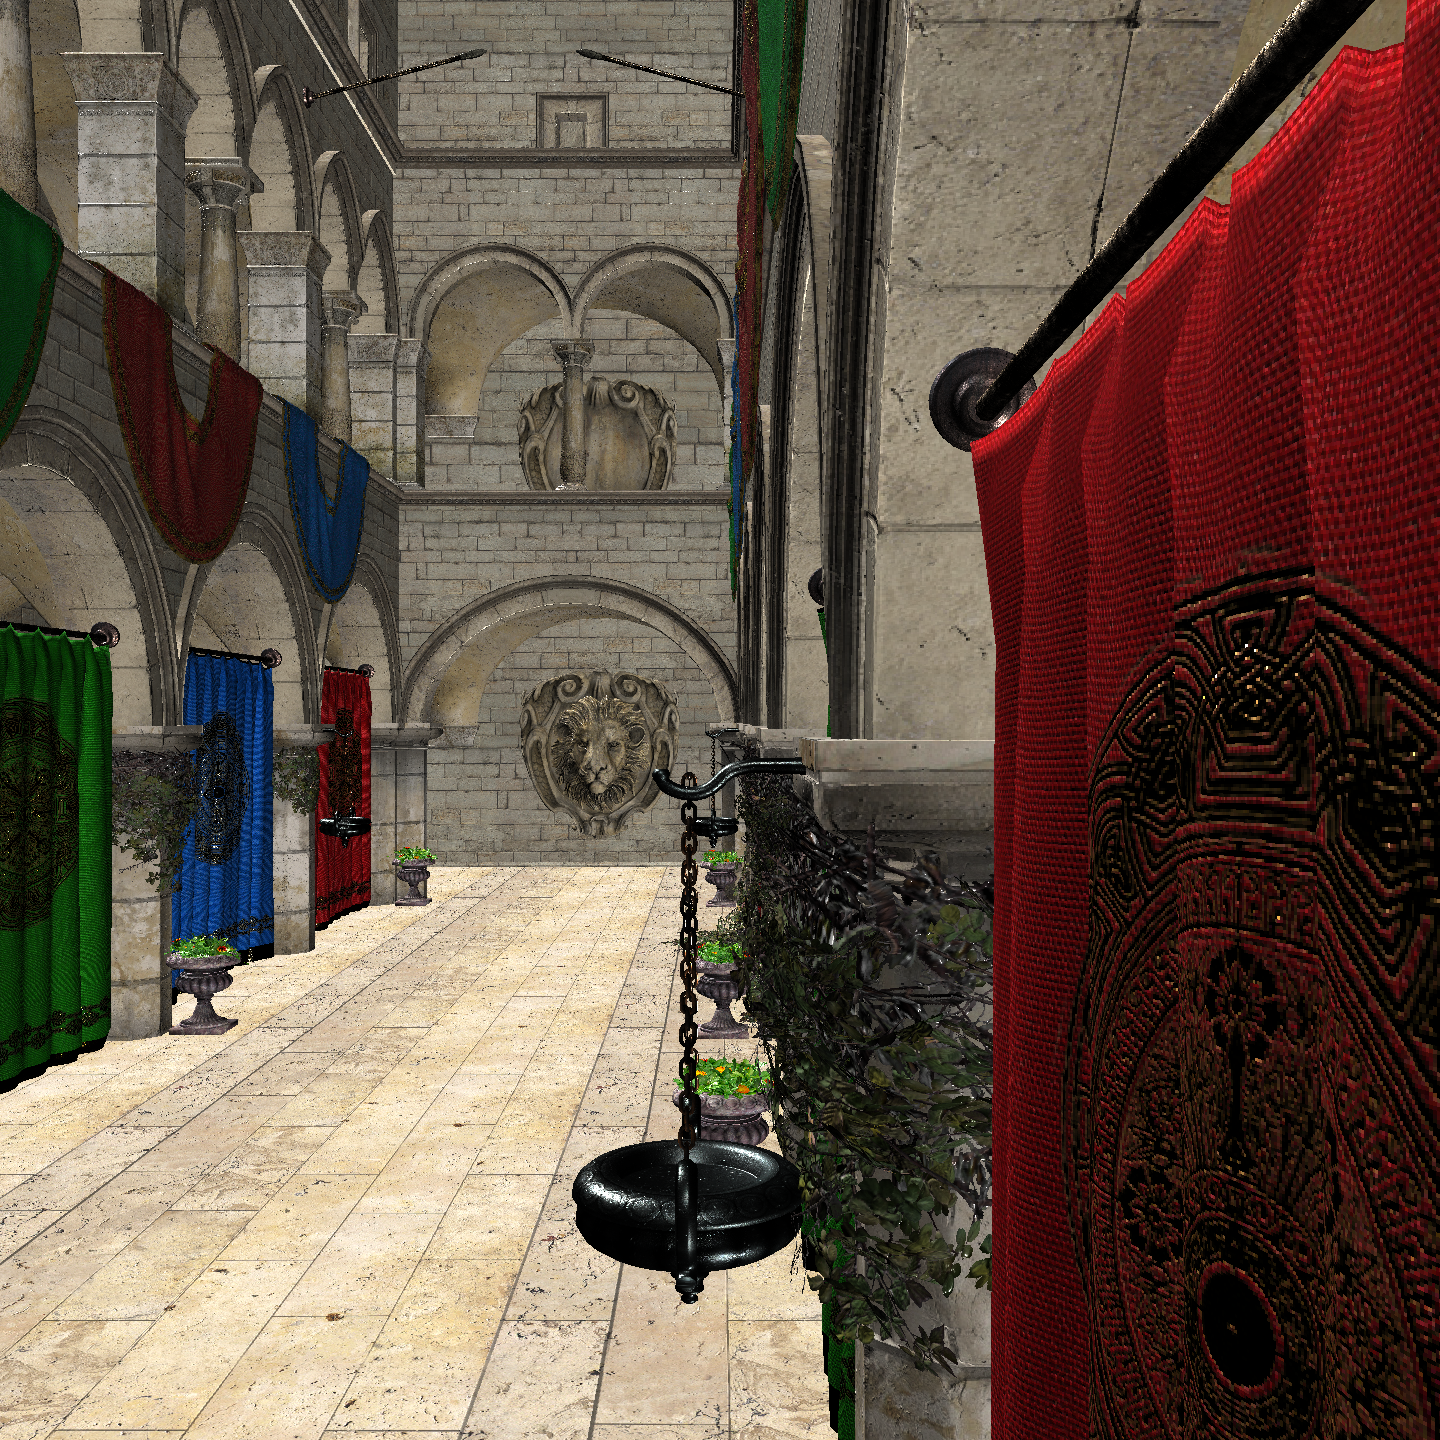

In [3]:
retina_size = 17.0

rotation = np.array([[0.0, 0.0, 1.0],
                     [0.0, 1.0, 0.0],
                     [1.0, 0.0, 0.0]])

translation = np.array([-150.0, -225.0, -800.0])

scene = Scene3D('../models/gltf/sponza/Sponza.gltf', rotation, translation)

res_x = 1440
res_y = 1440

org_x = np.zeros(res_x * res_y, dtype=np.float32)
org_y = np.zeros(res_x * res_y, dtype=np.float32)
org_z = np.zeros(res_x * res_y, dtype=np.float32)

dst_x = np.repeat(np.linspace(-0.5, 0.5, num=res_x) * retina_size, res_y)
dst_y = np.tile(np.linspace(-0.5, 0.5, num=res_y) * retina_size, res_x)
dst_z = np.ones(res_x * res_y, dtype=np.float32) * (-17.0)

ray_origins = np.stack(np.broadcast_arrays(org_x, org_y, org_z), axis=-1)
ray_directions = np.stack(np.broadcast_arrays(dst_x, dst_y, dst_z), axis=-1) - ray_origins
ray_directions /= np.sqrt(dot(ray_directions, ray_directions))[..., np.newaxis]

light_values = np.array([[1.2, 1.2, 1.2], [0.8, 0.8, 0.8], [0.6, 0.6, 0.6]])
light_directions = np.array([[0.5, -0.7, 0.5], [-0.5, 0.7, -0.5], [0.0, -0.7, -0.7]])
light_directions /= np.sqrt(dot(light_directions, light_directions))[..., np.newaxis]

ray_color = scene.rayCast(ray_origins, ray_directions, light_values, light_directions)
#%timeit scene.rayCast(ray_origins, ray_directions, light_values, light_directions)

array_stats(ray_color)
ray_color = np.clip(ray_color, 0.0, 1.0)

display_image(np.moveaxis(ray_color, -1, 0).reshape(3, res_x, res_y))

scene.release()